In [1]:
"""
Test the false positive rate of PH calculation looking at pairs of Principal Component Analysis dimensions. 
"""
%load_ext autoreload
%autoreload 2 
from ripser import ripser
import anndata as ad 
from matplotlib import pyplot as plt
from topo import viz
import numpy as np
from persim import bottleneck
import random
from tqdm import tqdm
from itertools import combinations
from sklearn.decomposition import PCA
from totopos.utils.ph_utils import get_lifetimes
from totopos.topology.neighborhood import largest_neighborhood_lifetime
import totopos.cells as tpc
from totopos import viz as tv

viz.set_plotting_style_plt()
a = ad.read_h5ad("/home/mnu/projects/topo/data/worm/worm_cv.h5ad")

## PCA marginals negative control 

In this notebook we want to ask, what is the False Positive Rate of persistent homology class detection when using PCA projection. 
To do so, we will check if, we can get spurious homology classes by projection, when using a dataset with no significant homology classes in 20 dimensions.

In [2]:
n_pcs = 20

# select a random cell type with more than 1000 and less than 5000 cells
# this helps to compare with the cnidocyte analysis and also for computational efficiency
cell_type_counts=a.obs["cell_type"].value_counts()

In [3]:
cell_type_counts_thresh = cell_type_counts[(cell_type_counts>1000) & (cell_type_counts<5000)]

In [4]:
random.seed(47)
cell_type = random.choice(cell_type_counts_thresh.index)

In [5]:
ada=a[a.obs.cell_type==cell_type].copy()
print(f"Using cell type: {cell_type}, which has {ada.n_obs} cells.")

Using cell type: Pharyngeal_muscle, which has 2562 cells.


In [6]:
pca = PCA()
pca.fit(ada.X.A)
pcs = pca.transform(ada.X.A)
pcs=pcs[:,:n_pcs]

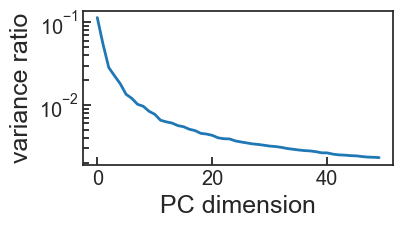

In [7]:
plt.figure(figsize=(4,2))
plt.plot(pca.explained_variance_ratio_[:50])
plt.xlabel("PC dimension")
plt.ylabel("variance ratio")
plt.yscale("log")

The following plot is a PCA projection using overlapping windows of size 3. That is, each plot is a 3D PCA plot, the first one looks at PCs (1,2,3), then (2,3,4), and so on.

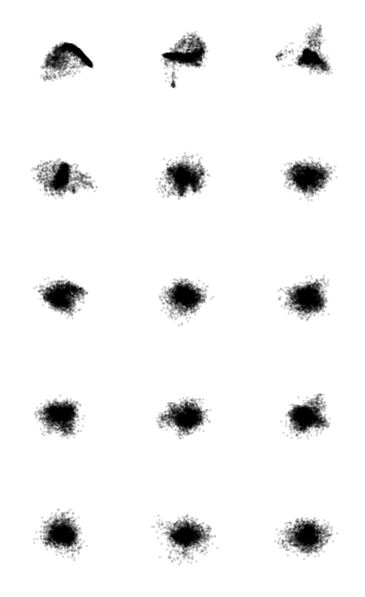

In [8]:
fig=viz.plot_pca_marginals(pcs,n=15,grid=True,plot_size=1.5,plot_every=1)

### Persistent homology analysis.

To set a base to compare to, we're going to compute persistent homology on the first 20 PCs. **We will deem a 1-homology class "significant" if its lifetime is twice as large, or more than the lifetime across all classes, computed on neighborhoods of size $\approx 200$, where neighborhoods are defined as kMeans clustering.** We add the function here for completeness, but it is implemented in `totopos.topology.neighborhood`.

```
def largest_neighborhood_lifetime(
    data, 
    n_clusters=20,
    ph_dim=1,
    use_tqdm=True
): 
    """Returns the noise floor $\alpha$ defined as the largest PH lifetime across k neighborhoods using kmeans clustering.

    Params
    ------
    data (np.ndarray)
        Point cloud on which to compute the persistent homology. 

    n_clusters(int)
        Parameter k for Kmeans clustering. 
    
    ph_dim (int)
        Dimension for PH to focus on.
    """
    
    km = kmeans(n_clusters=n_clusters,random_state=13)
    km.fit(data)
    labels=km.predict(data)
    largest_nbd_lifetime=0
    neighborhood_lifetimes = []
    iterable = range(n_clusters)
    
    for i in iterable:
        persistence_diagram = ripser(data[labels==i],maxdim=ph_dim)["dgms"][ph_dim]
        neighborhood_lifetimes.extend(get_lifetimes(persistence_diagram))
        if len(persistence_diagram)>0:
            largest_lt_clus = get_largest_lifetime_from_diagram(persistence_diagram)
            if largest_lt_clus > largest_nbd_lifetime:
                largest_nbd_lifetime = largest_lt_clus
    return largest_nbd_lifetime, neighborhood_lifetimes
```

In [9]:
## Calulate base ph and compute neighborhood threshold 
neighborhood_size = 200
ph_base = ripser(pcs, maxdim=1, do_cocycles=True)
nbd_thresh, nbd_lifetimes = largest_neighborhood_lifetime(pcs, n_clusters=ada.n_obs//neighborhood_size)

Estimating PH noise floor using Voronoi neighborhoods...: 100%|█████| 12/12 [00:00<00:00, 23.43it/s]


Now, lets see if there's a significant class for this dataset.

In [10]:
lifetimes = get_lifetimes(ph_base["dgms"][1])
n_prominent_feats_ = sum(lifetimes >= 2*nbd_thresh)

print(f"Found {n_prominent_feats_} persistent classes for cell type: {cell_type}")

Found 0 persistent classes for cell type: Pharyngeal_muscle


So based on our heuristic, we can say that there is no significant persistent homology class from this dataset. Hence, if we find any significant class in the projection, we can say that those will be false positives.

In [11]:
pd_pal = ["#000000", "#212b61"]

Text(0.5, 1.0, 'Pers diagram on 20 PCs')

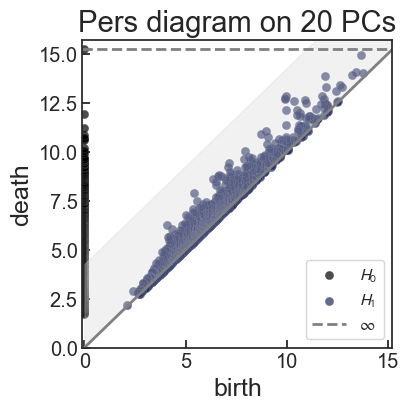

In [12]:
plt.figure(figsize=(4,4))
viz.plot_pers_diag_ripser(ph_base["dgms"],conf_int=2*nbd_thresh, pal = pd_pal)
plt.title("Pers diagram on 20 PCs")

### Negative control
We'll do the following. For each pair of the $20 \choose 2$ dimensions:
1. Compute PH.
2. Determine if there are significant persistent homology classes.

In [13]:
pairs = list(combinations(range(20),2))
print("These are some of the dimensions we will test : ", pairs[::30])

These are some of the dimensions we will test :  [(0, 1), (1, 13), (3, 10), (5, 11), (7, 16), (10, 16), (15, 16)]


In [14]:
ph_dict = {}

## compute ph for all pairs
for p in tqdm(pairs): 
    i,j = p
    ph_dict[f"{i}_{j}"] = {}
    pc_marginal = pcs[:,p]
    
    ph_marginal=ripser(pc_marginal, maxdim=1, do_cocycles=True)
    ph_dict[f"{i}_{j}"]["ph"] = ph_marginal

    nbd_thresh_marginal, nbd_lifetimes = largest_neighborhood_lifetime(
        pc_marginal, n_clusters = ada.n_obs//neighborhood_size, use_tqdm=False
    )
    
    # compute neighborhood threshold 
    ph_dict[f"{i}_{j}"]["threshold"] =nbd_thresh_marginal
    ph_dict[f"{i}_{j}"]["lifetimes"] = nbd_lifetimes
    # 
    lifetimes_marginal = get_lifetimes(ph_marginal["dgms"][1])
    n_prominent_feats_ = sum(lifetimes_marginal >= 2*nbd_thresh_marginal)

    ph_dict[f"{i}_{j}"]["is_significant"] = n_prominent_feats_ > 0

100%|█████████████████████████████████████████████████████████████| 190/190 [16:19<00:00,  5.16s/it]


Let's check if there are false positives, and if so, let's compute the $H_1$ generators to visualize them. 

In [15]:
false_positive_pairs = []
for p in pairs:
    i,j=p
    if ph_dict[f"{i}_{j}"]["is_significant"]:
        false_positive_pairs.append(p)


for p in tqdm(false_positive_pairs): 
    i,j=p
    loop_data = tpc.critical_edge_method(
        pcs[:,p],ph=ph_dict[f"{i}_{j}"]["ph"],n_loops=1,
    )

    ph_dict[f"{i}_{j}"]["loop_data"] = loop_data

100%|█████████████████████████████████████████████████████████████████| 9/9 [01:49<00:00, 12.17s/it]


In [16]:
print(f"Found {len(false_positive_pairs)} significant pairs out of {len(pairs)} total pairs.")

Found 9 significant pairs out of 190 total pairs.


In [17]:
false_positive_rate=len(false_positive_pairs)/len(pairs)*100
print(f"False positive rate: {false_positive_rate:.2f}%")

False positive rate: 4.74%


Let's visualize the false positive pairs.

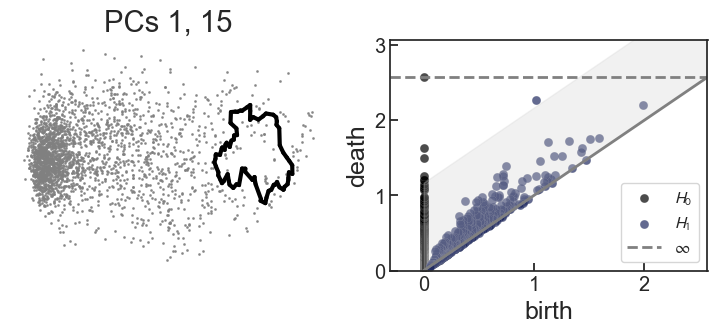

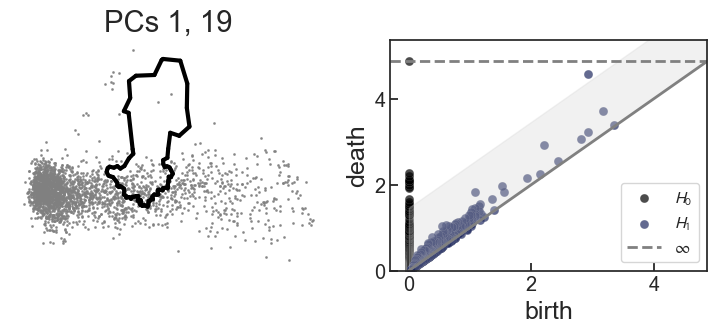

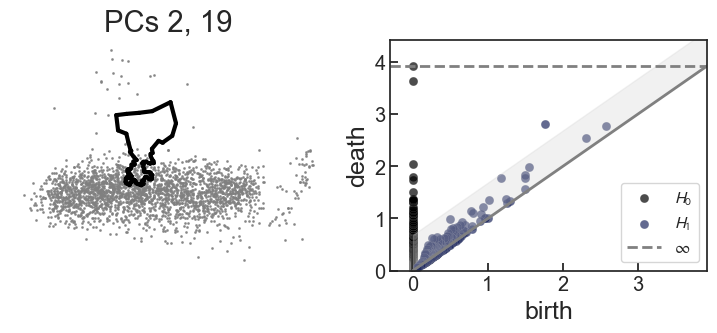

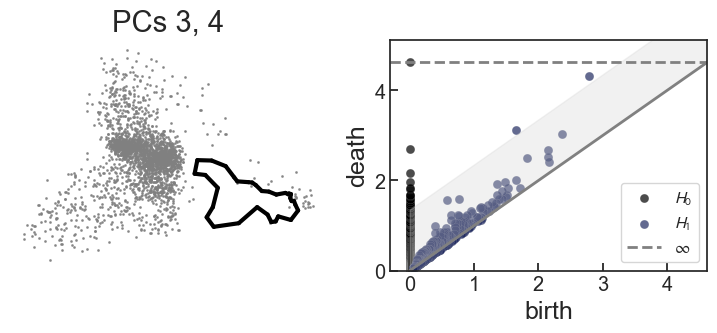

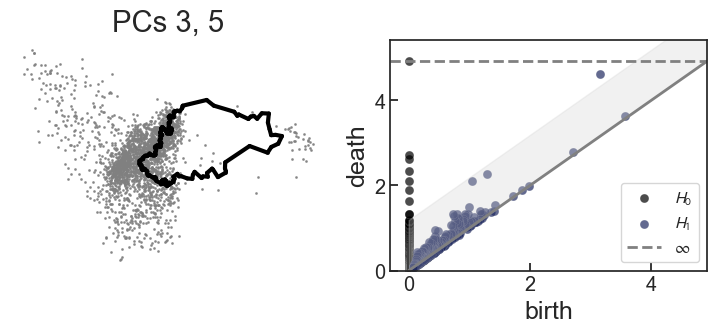

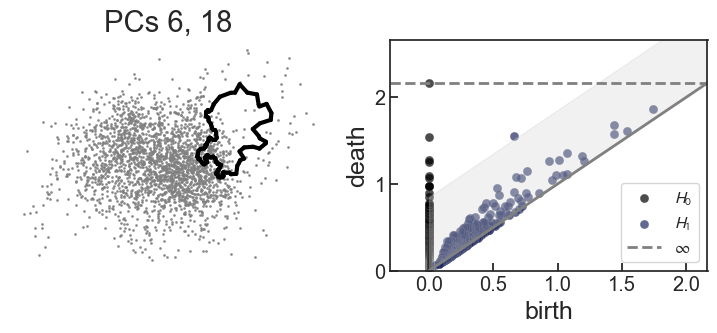

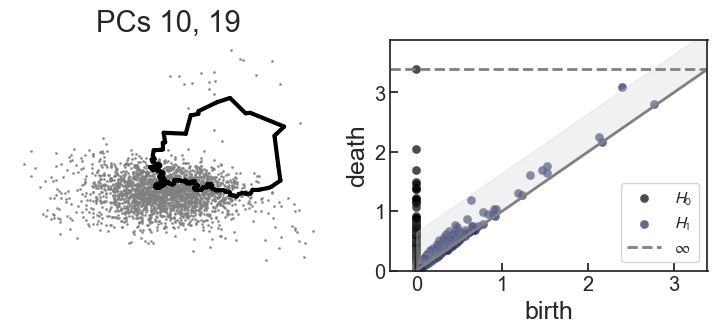

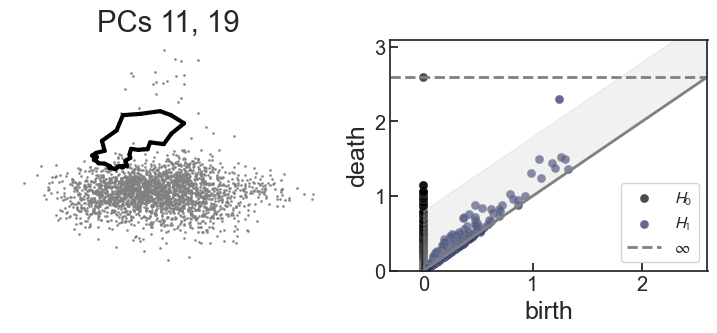

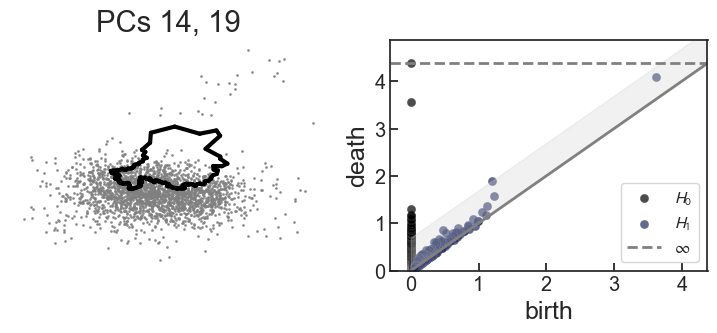

In [21]:
for p in false_positive_pairs:
    i,j=p

    ## PCA PLOT 
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharex=False, sharey=False)
    tv.visualize_h1(
        pcs[:, p],
        h1_simplex_list=[ph_dict[f"{i}_{j}"]["loop_data"][0]["loop"]],
        pal=pd_pal,
        ax = axs[0],
        d = 2,
        alpha = .8
    )
    axs[0].set_title(f"PCs {i+1}, {j+1}")
    axs[0].set_xlabel(f"pc {i+1}")
    axs[0].set_ylabel(f"pc {j+1}")

    
    ## PERSISTENT DIAGRAM
    tv.cloud.plot_pers_diag_ripser(
        ph_dict[f"{i}_{j}"]["ph"]["dgms"],
        conf_int=2 * ph_dict[f"{i}_{j}"]["threshold"],
        pal=pd_pal,
        ax=axs[1]  
    )


### False positives can be driven by outliers.

Based on the cases above, we deem that the false positives may be driven by the effect outliers. 

We can check if this is the case by computing the number of neighbors in each of the representative cells from a loop.

In [22]:
pair=false_positive_pairs[1]
i,j=pair
h1_simplex_list=ph_dict[f"{i}_{j}"]["loop_data"][0]["loop"]

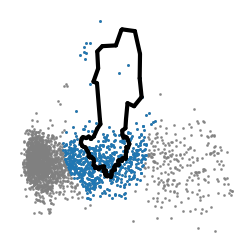

In [23]:
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot()
tv.visualize_h1(
    pcs[:, pair],
    h1_simplex_list=[h1_simplex_list],
    pal=pd_pal,
    d = 2,
    alpha = .8,
    ax=ax
)
ax.scatter(*ph_dict[f"{i}_{j}"]["loop_data"][0]["topocells"].T,s=1)

In [24]:
zero_sk=np.unique(ph_dict[f"{i}_{j}"]["loop_data"][0]["loop"])

In [25]:
birth_dist = ph_dict[f"{i}_{j}"]["loop_data"][0]["birth_dist"]

In [26]:
pc_marginals= pcs[:, pair]

In [27]:
from sklearn.metrics import pairwise_distances

In [28]:
neighbor_list=[]
for representative_cell in zero_sk: 
    D = pairwise_distances([pc_marginals[representative_cell]], pc_marginals).flatten()
    neighbors= np.where(D<=birth_dist)[0]
    neighbor_list.append(neighbors)

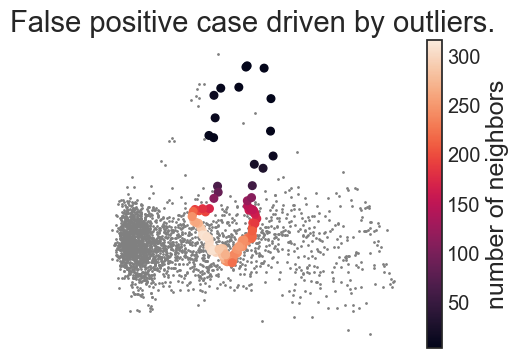

In [29]:
plt.figure(figsize=(5,4))
plt.scatter(*pcs[:,pair].T,s=1, color = "grey")
plt.scatter(
    *pcs[zero_sk][:, pair].T,s=30, c = [len(n) for n in neighbor_list],
)

plt.colorbar(label="number of neighbors")
plt.title("False positive case driven by outliers.")
plt.axis("off");